In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data as Data
import torchvision.datasets
import torchvision.transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from pyampd.ampd import find_peaks


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


# Data Preprocessing

In [2]:
PPG_datas = []
ABP_datas = []
ECG_datas = []
i = 0
for name in glob.glob('./dataset/*.csv'):
    raw_training_data = pd.read_csv(name, header=None)
    raw_training_data = np.array(raw_training_data)
    #print(raw_training_data.shape)
    PPG_data = raw_training_data[0].reshape(-1)
    ABP_data = raw_training_data[1].reshape(-1)
    ECG_data = raw_training_data[2].reshape(-1)
    
    PPG_datas.append(PPG_data)
    ABP_datas.append(ABP_data)
    ECG_datas.append(ECG_data)
    i = i + 1
    print(i)
#     if (i == 100):
#         break

PPG_datas = np.array(PPG_datas)
ABP_datas = np.array(ABP_datas)
ECG_datas = np.array(ECG_datas)

#raw_training_data.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [3]:
def generate_whole_based_vector(X):
    vector = np.zeros(4 * SAMPLE_FREQ)
    vector[:len(X)] = X
    return vector
    

In [18]:
SAMPLE_FREQ = 125
EPOCHS = 2
LR = 0.001

In [5]:
#generate dataset
whole_based_vectors = []
SBP_data = []
DBP_data = []
MAP_data = []

for j in range(len(PPG_datas)):
    sec_15 = 15*SAMPLE_FREQ
    PPG_data = PPG_datas[j]
    ABP_data = ABP_datas[j]
    PPG_peaks = find_peaks(PPG_data, scale=SAMPLE_FREQ)
    for i in range(2, PPG_peaks.shape[0]):
        X = PPG_data[PPG_peaks[i-1]:PPG_peaks[i]]
        if(len(X) < SAMPLE_FREQ):
            whole_based_vector = generate_whole_based_vector(X)

            SBP = np.max(ABP_data[PPG_peaks[i-1]:PPG_peaks[i-1]+sec_15])
            DBP = np.min(ABP_data[PPG_peaks[i-1]:PPG_peaks[i-1]+sec_15])
            MAP = SBP/3 + 2*DBP/3

            whole_based_vectors.append(whole_based_vector)
            SBP_data.append(SBP)
            DBP_data.append(DBP)
            MAP_data.append(MAP)

In [6]:
whole_based_vectors = np.array(whole_based_vectors)
SBP_data = np.array(SBP_data)
DBP_data = np.array(DBP_data)
MAP_data = np.array(MAP_data)
print(whole_based_vectors.shape)
print(SBP_data.shape)

(196625, 500)
(196625,)


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=43)
pca_whole_based_vectors = pca.fit_transform(whole_based_vectors)

print(pca_whole_based_vectors.shape)

(196625, 43)


# LSTM , NN Module

In [8]:
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.input = nn.Linear(in_features=input_size, out_features=256)
        self.hidden1 = nn.Linear(in_features=256, out_features=512)
        self.hidden2 = nn.Linear(in_features=512, out_features=256)
        self.hidden3 = nn.Linear(in_features=256, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.dropout = nn.Dropout(p=0.2)
        self.activation = lambda X: F.relu(X)
    
    def forward(self, x):
        out = self.input(x)
        out = self.hidden1(self.activation(out))
        out = self.dropout(out)
        out = self.hidden2(self.activation(out))
        out = self.hidden3(self.activation(out))
#         out = self.dropout(out)
        out = self.output(self.activation(out))
        return out
    
    def get_weight(self):
        weight = []
        weight.append(self.input.weight)
        weight.append(self.hidden1.weight)
        weight.append(self.hidden2.weight)
        weight.append(self.hidden3.weight)
        weight.append(self.output.weight)
        return weight

In [32]:
torch.set_default_tensor_type(torch.FloatTensor)

class module():
    def __init__(self, net, train_loader, test_loader, EPOCH=20, LR=0.0001):
        self.net = net
        self.optimizer = torch.optim.Adam(net.parameters(), lr = LR)
        self.criterion = nn.MSELoss()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCHS = EPOCH
        self.LR = LR

        self.net = self.net.to(device)
        if device == 'cuda':
            # self.net = torch.nn.DataParallel(self.net)
            torch.backends.cudnn.benchmark = True

    def start(self):

        self.history_train_loss = []
        self.history_test_loss = []
#         history_train_accuracy = []
#         history_test_accuracy = []
        for epoch in range(self.EPOCHS):
            print('Epoch:', epoch)
            train_loss = self.train()
            test_loss = self.test()

            self.history_train_loss.append(train_loss)
            self.history_test_loss.append(test_loss)
#             history_train_accuracy.append(train_accuracy)
#             history_test_accuracy.append(test_accuracy)

    def train(self):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.net(batch_X).double()
            
            loss = self.criterion(outputs.reshape(-1), batch_y)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            #_, predicted = outputs.max(1)
            #total += batch_y.size(0)
            #correct += predicted.eq(batch_y).sum().item()        

        print('【Training】Loss: %.3f ' % ( train_loss))
        return train_loss

    def test(self):
        self.net.eval()

        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X).double()
                loss = self.criterion(outputs.reshape(-1), batch_y)

                test_loss += loss.item()
#                 _, predicted = outputs.max(1)
#                 #print(predicted, batch_y)
#                 total += batch_y.size(0)
#                 correct += predicted.eq(batch_y).sum().item()   

        print('【Testing】Loss: %.3f )' % ( test_loss))
        return test_loss
    
    def predict(self, test_loader):
        outputs = []
        self.net.eval()

        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = self.net(batch_X).double().cpu().numpy().reshape(-1)
                for i in range(len(output)):
                    outputs.append(output[i])
                
        return outputs
    
    def get_weight(self):
        return self.net.get_weight()
    
    def get_model(self):
        return self.net.state_dict()

# Training

In [33]:
from sklearn.model_selection import train_test_split

L = 43

x_train, x_test, SBP_train, SBP_test, DBP_train, DBP_test, MAP_train, MAP_test = train_test_split(
                                            pca_whole_based_vectors, SBP_data, DBP_data, MAP_data, test_size=0.1, random_state=42)


x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
SBP_train = torch.from_numpy(SBP_train)
SBP_test = torch.from_numpy(SBP_test)
DBP_train = torch.from_numpy(DBP_train)
DBP_test = torch.from_numpy(DBP_test)
MAP_train = torch.from_numpy(MAP_train)
MAP_test = torch.from_numpy(MAP_test)

x_train = x_train.view(-1, 1, L)
x_test = x_test.view(-1, 1, L)

print(x_train.shape, x_test.shape, SBP_train.shape, SBP_test.shape)

SBP_train_dataset = Data.TensorDataset(x_train, SBP_train)
SBP_test_dataset = Data.TensorDataset(x_test, SBP_test)


SBP_train_loader = Data.DataLoader(
    dataset = SBP_train_dataset,
    batch_size = 128,
)

SBP_test_loader = Data.DataLoader(
    dataset = SBP_test_dataset,
    batch_size = 10,
)

DBP_train_dataset = Data.TensorDataset(x_train, DBP_train)
DBP_test_dataset = Data.TensorDataset(x_test, DBP_test)


DBP_train_loader = Data.DataLoader(
    dataset = DBP_train_dataset,
    batch_size = 128,
)

DBP_test_loader = Data.DataLoader(
    dataset = DBP_test_dataset,
    batch_size = 10,
)

MAP_train_dataset = Data.TensorDataset(x_train, MAP_train)
MAP_test_dataset = Data.TensorDataset(x_test, MAP_test)


MAP_train_loader = Data.DataLoader(
    dataset = MAP_train_dataset,
    batch_size = 128,
)

MAP_test_loader = Data.DataLoader(
    dataset = MAP_test_dataset,
    batch_size = 10,
)


torch.Size([176962, 1, 43]) torch.Size([19663, 1, 43]) torch.Size([176962]) torch.Size([19663])


In [28]:
def AAMI_standard(predict, test):
    total = len(predict)
    ME = np.mean(predict - test)
    MAE = np.mean(np.abs(predict-test))
    SD = np.std(predict-test)
    
    return total, ME, MAE, SD
    
def BHS_standard(predict, test):
    total = len(predict)
    mm5 = np.sum(np.abs(predict-test)<=5)
    mm10 = np.sum(np.abs(predict-test)<=10)
    mm15 = np.sum(np.abs(predict-test)<=15)
    return total, mm5, mm10, mm15

In [12]:
# lstm_module10 = module(LSTM(input_size=L), SBP_train_loader, SBP_test_loader, EPOCH=EPOCHS, LR=LR)
# history_loss = lstm_module10.start()



In [13]:
# print(test_loader)
# print(SBP_test_dataset)

In [14]:
# SBP_predict = np.array(lstm_module10.predict(SBP_test_loader)).reshape(-1)
# # temp_predict = []
# # for predicts in SBP_predict:
# #     for i in range(len(predicts))
# #         temp_predict.append(predicts[i])  
# print(SBP_predict[0:20])
# SBP_test = np.array(SBP_test)
# print(SBP_test[0:20])

# print('Long-Short-Term Memory')

# total, ME, MAE, SD = AAMI_standard(SBP_predict, SBP_test)
# print()
# print()
# print('----------------SBP-----------------')
# print()
# print('-------------AAMI standard----------')
# print('ME             MAE             SD           total')
# print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
# #print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
# total, mm5, mm10, mm15 = BHS_standard(SBP_predict, SBP_test)
# print()
# print('-------------BHS standard------------')
# print('<5mmHg        <10mmHg        <15mmHg        total')
# print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
# print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

In [34]:
SBP_nn_module = module(NN(input_size=L), SBP_train_loader, SBP_test_loader, EPOCH=200, LR=LR)
SBP_nn_module.start()

DBP_nn_module = module(NN(input_size=L), DBP_train_loader, DBP_test_loader, EPOCH=200, LR=LR)
DBP_nn_module.start()

MAP_nn_module = module(NN(input_size=L), MAP_train_loader, MAP_test_loader, EPOCH=200, LR=LR)
MAP_nn_module.start()

Epoch: 0
【Training】Loss: 997193.357 
【Testing】Loss: 714463.476 )
Epoch: 1
【Training】Loss: 484064.788 
【Testing】Loss: 621287.503 )
Epoch: 2
【Training】Loss: 439334.219 
【Testing】Loss: 602259.562 )
Epoch: 3
【Training】Loss: 415123.793 
【Testing】Loss: 575803.774 )
Epoch: 4
【Training】Loss: 398017.429 
【Testing】Loss: 566511.082 )
Epoch: 5
【Training】Loss: 386797.983 
【Testing】Loss: 548189.950 )
Epoch: 6
【Training】Loss: 376795.989 
【Testing】Loss: 555495.465 )
Epoch: 7
【Training】Loss: 367623.280 
【Testing】Loss: 544341.053 )
Epoch: 8
【Training】Loss: 359972.205 
【Testing】Loss: 506403.593 )
Epoch: 9
【Training】Loss: 353678.717 
【Testing】Loss: 517934.063 )
Epoch: 10
【Training】Loss: 346785.900 
【Testing】Loss: 488040.925 )
Epoch: 11
【Training】Loss: 341146.211 
【Testing】Loss: 496165.489 )
Epoch: 12
【Training】Loss: 336857.152 
【Testing】Loss: 499567.425 )
Epoch: 13
【Training】Loss: 332167.866 
【Testing】Loss: 469119.646 )
Epoch: 14
【Training】Loss: 327436.705 
【Testing】Loss: 471633.139 )
Epoch: 15
【Training】

【Training】Loss: 222442.298 
【Testing】Loss: 346002.611 )
Epoch: 125
【Training】Loss: 221597.408 
【Testing】Loss: 340815.346 )
Epoch: 126
【Training】Loss: 220968.834 
【Testing】Loss: 337194.202 )
Epoch: 127
【Training】Loss: 220240.123 
【Testing】Loss: 349107.277 )
Epoch: 128
【Training】Loss: 220336.740 
【Testing】Loss: 343569.809 )
Epoch: 129
【Training】Loss: 218725.606 
【Testing】Loss: 340203.709 )
Epoch: 130
【Training】Loss: 218849.261 
【Testing】Loss: 340361.802 )
Epoch: 131
【Training】Loss: 219047.731 
【Testing】Loss: 339504.844 )
Epoch: 132
【Training】Loss: 218441.669 
【Testing】Loss: 339071.975 )
Epoch: 133
【Training】Loss: 218062.509 
【Testing】Loss: 334673.449 )
Epoch: 134
【Training】Loss: 217546.394 
【Testing】Loss: 339170.342 )
Epoch: 135
【Training】Loss: 216162.169 
【Testing】Loss: 342194.283 )
Epoch: 136
【Training】Loss: 216385.197 
【Testing】Loss: 345722.597 )
Epoch: 137
【Training】Loss: 215587.691 
【Testing】Loss: 342271.657 )
Epoch: 138
【Training】Loss: 216268.655 
【Testing】Loss: 336474.105 )
Epoch:

【Training】Loss: 63391.661 
【Testing】Loss: 93115.775 )
Epoch: 49
【Training】Loss: 63274.756 
【Testing】Loss: 94977.691 )
Epoch: 50
【Training】Loss: 63037.067 
【Testing】Loss: 93786.470 )
Epoch: 51
【Training】Loss: 62236.574 
【Testing】Loss: 95469.931 )
Epoch: 52
【Training】Loss: 62248.299 
【Testing】Loss: 91685.923 )
Epoch: 53
【Training】Loss: 61799.621 
【Testing】Loss: 92884.559 )
Epoch: 54
【Training】Loss: 61321.040 
【Testing】Loss: 91613.994 )
Epoch: 55
【Training】Loss: 61270.064 
【Testing】Loss: 92117.738 )
Epoch: 56
【Training】Loss: 60802.099 
【Testing】Loss: 91934.378 )
Epoch: 57
【Training】Loss: 60271.668 
【Testing】Loss: 90512.183 )
Epoch: 58
【Training】Loss: 60108.023 
【Testing】Loss: 90954.519 )
Epoch: 59
【Training】Loss: 59983.621 
【Testing】Loss: 90998.801 )
Epoch: 60
【Training】Loss: 59761.496 
【Testing】Loss: 92278.310 )
Epoch: 61
【Training】Loss: 59138.878 
【Testing】Loss: 91944.694 )
Epoch: 62
【Training】Loss: 59261.638 
【Testing】Loss: 90931.943 )
Epoch: 63
【Training】Loss: 58837.781 
【Testing】Loss

【Training】Loss: 30774.585 
【Testing】Loss: 79448.317 )
Epoch: 176
【Training】Loss: 30746.347 
【Testing】Loss: 78151.160 )
Epoch: 177
【Training】Loss: 30727.547 
【Testing】Loss: 81962.339 )
Epoch: 178
【Training】Loss: 30842.899 
【Testing】Loss: 80396.154 )
Epoch: 179
【Training】Loss: 30494.608 
【Testing】Loss: 77562.002 )
Epoch: 180
【Training】Loss: 29713.587 
【Testing】Loss: 80693.698 )
Epoch: 181
【Training】Loss: 30091.682 
【Testing】Loss: 79714.967 )
Epoch: 182
【Training】Loss: 30037.479 
【Testing】Loss: 81580.991 )
Epoch: 183
【Training】Loss: 29946.515 
【Testing】Loss: 82943.902 )
Epoch: 184
【Training】Loss: 29982.465 
【Testing】Loss: 81571.913 )
Epoch: 185
【Training】Loss: 29844.444 
【Testing】Loss: 82418.191 )
Epoch: 186
【Training】Loss: 29600.604 
【Testing】Loss: 80499.254 )
Epoch: 187
【Training】Loss: 29773.901 
【Testing】Loss: 82300.434 )
Epoch: 188
【Training】Loss: 29768.054 
【Testing】Loss: 85051.119 )
Epoch: 189
【Training】Loss: 29284.245 
【Testing】Loss: 81511.474 )
Epoch: 190
【Training】Loss: 28977.415

【Training】Loss: 63698.945 
【Testing】Loss: 100852.275 )
Epoch: 102
【Training】Loss: 63632.748 
【Testing】Loss: 102959.192 )
Epoch: 103
【Training】Loss: 62948.932 
【Testing】Loss: 102179.856 )
Epoch: 104
【Training】Loss: 62625.159 
【Testing】Loss: 102758.942 )
Epoch: 105
【Training】Loss: 62428.576 
【Testing】Loss: 102529.661 )
Epoch: 106
【Training】Loss: 62396.099 
【Testing】Loss: 100900.443 )
Epoch: 107
【Training】Loss: 62077.970 
【Testing】Loss: 100672.616 )
Epoch: 108
【Training】Loss: 62112.827 
【Testing】Loss: 100332.517 )
Epoch: 109
【Training】Loss: 61958.510 
【Testing】Loss: 102216.353 )
Epoch: 110
【Training】Loss: 61424.474 
【Testing】Loss: 101014.314 )
Epoch: 111
【Training】Loss: 61166.742 
【Testing】Loss: 100404.780 )
Epoch: 112
【Training】Loss: 60821.695 
【Testing】Loss: 99962.638 )
Epoch: 113
【Training】Loss: 60952.874 
【Testing】Loss: 100418.378 )
Epoch: 114
【Training】Loss: 60362.534 
【Testing】Loss: 100533.836 )
Epoch: 115
【Training】Loss: 60245.820 
【Testing】Loss: 101134.774 )
Epoch: 116
【Training】L

In [35]:

# temp_predict = []
# for predicts in SBP_predict:
#     for i in range(len(predicts))
#         temp_predict.append(predicts[i])  
# print(SBP_predict[0:20])

# print(SBP_test[0:20])

SBP_predict = np.array(SBP_nn_module.predict(SBP_test_loader)).reshape(-1)
SBP_test = np.array(SBP_test)
DBP_predict = np.array(DBP_nn_module.predict(DBP_test_loader)).reshape(-1)
DBP_test = np.array(DBP_test)
MAP_predict = np.array(MAP_nn_module.predict(MAP_test_loader)).reshape(-1)
MAP_test = np.array(MAP_test)

print('Fully Connected Nueral Network')

total, ME, MAE, SD = AAMI_standard(SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

Fully Connected Nueral Network


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.371         8.321         12.806          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
9819            14430           16503          19663
49.936%        73.387%       83.929%         19663


----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
1.049         3.818         6.262          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
15158            18078           18980          19663
77.089%        91.939%       96.526%         19663


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
1.317         4.440         6.772          19663

-------------BHS standard------------
<5mmHg        

In [36]:
print('Fully Connected Neural Network')

SBP_cc= np.corrcoef(SBP_predict, SBP_test)
DBP_cc= np.corrcoef(DBP_predict, DBP_test)
MAP_cc= np.corrcoef(MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (MAP_cc[0, 1]))

Fully Connected Neural Network


------------Correlation Coefficient-------------

SBP: 0.817

DBP: 0.795

MAP: 0.816


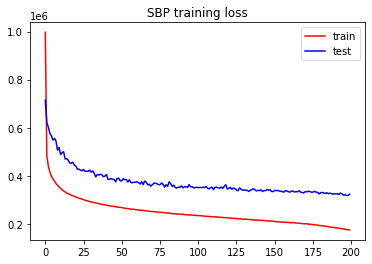

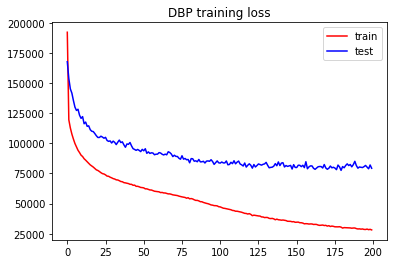

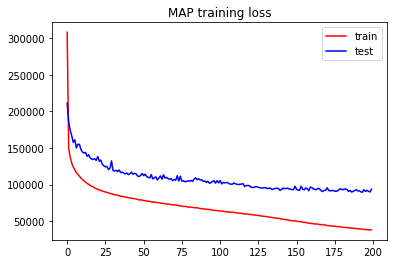

In [39]:
plt.figure()
plt.title('SBP training loss')
plt.plot(SBP_nn_module.history_train_loss, color='red', label='train')
plt.plot(SBP_nn_module.history_test_loss, color='blue', label='test')
plt.legend()
plt.show()

plt.figure()
plt.title('DBP training loss')
plt.plot(DBP_nn_module.history_train_loss, color='red', label='train')
plt.plot(DBP_nn_module.history_test_loss, color='blue', label='test')
plt.legend()
plt.show()

plt.figure()
plt.title('MAP training loss')
plt.plot(MAP_nn_module.history_train_loss, color='red', label='train')
plt.plot(MAP_nn_module.history_test_loss, color='blue', label='test')
plt.legend()
plt.show()


In [40]:
torch.save(SBP_nn_module.get_model(), './model/SBP_nn.tar')
torch.save(DBP_nn_module.get_model(), './model/DBP_nn.tar')
torch.save(MAP_nn_module.get_model(), './model/MAP_nn.tar')

FileNotFoundError: [Errno 2] No such file or directory: './model/SBP_nn.tar'